# Run an initial peak detection with SciPy
Load the data from HDF5, make some plots to ensure we understand it, then get some peak locations

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

Configuration

In [2]:
span = [8.2, 6.8]
peak_kwargs = dict(width=0.007, prominence=0.12)

## Load the Tracks and Store Signals
The times are stored in `common` and the signals in parameters entitled `scan<id>`.
Each of the scans also has a metadata segment


In [3]:
def load_nmr_h5(path: str, span=[8.2, 6.8]) -> pd.DataFrame:
    """Load an HDF5 file into a Pandas data frame for later analysis
    
    Args:
        path: Location of the HDF5 file
        span: Range of data to plot
        points: Number of points to capture within this range
    Returns:
        Dataframe where each row is a different measurement.
    """
    
    with h5py.File(path) as h5_data:
        # Determine the number of times to sample from, and names of metadata for each
        common = h5_data['common']
        times = np.array(common['time delays, min'])
        fields = [x.decode() for x in common['parameter, name']]
        
        # Load each frame
        output = []
        offsets = None
        for i, time in enumerate(times):
            # Get the metadata
            page = h5_data[f'scan{i}']
            record = {'frame': i, 'time': time}
            record.update(dict(zip(fields, page['parameter, value'])))
            
            # Get the NMR data
            my_data = np.array(page['NMR spectrum'])
            my_offsets = record['offset, ppm'] + np.arange(len(my_data)) * record['delta, ppm']
            
            # Sample it to match the first frame (just in case)
            if offsets is None: 
                offsets = my_offsets.copy() if span is None else my_offsets[np.logical_and(my_offsets < max(span), my_offsets > min(span))]
            record['raw_signal'] = interp1d(my_offsets, my_data)(offsets)
            output.append(record)
        return pd.DataFrame(output), offsets

In [4]:
data, offsets = load_nmr_h5('raw-data/example-problem.h5', span=span)
data.head()

,frame,time,CD3CN,"offset, ppm","delta, ppm","freq, MHz","T, K",raw_signal
0,0,0.000000,NaN,10.729689,-0.00024,500.252655,298.150909,"[0.013013586401939392, 0.031242359429597855, 0..."
1,1,10.731133,NaN,10.729689,-0.00024,500.252655,298.150909,"[0.007046863902360201, 0.010115409968420863, 0..."
2,2,21.461466,NaN,10.729689,-0.00024,500.252655,298.150909,"[-0.03856595978140831, -0.03175279125571251, -..."
3,3,32.192551,NaN,10.729689,-0.00024,500.252655,298.150909,"[0.02139940671622753, 0.012769201770424843, -0..."
4,4,42.924252,NaN,10.729689,-0.00024,500.252655,298.150909,"[-0.008005277370102704, -0.001194242388010025,..."


## Interpolate the spectra
We take the measurements at non-even spacing. Let's interpolate just to life easier.

Text(0, 0.5, 'Time (hr)')

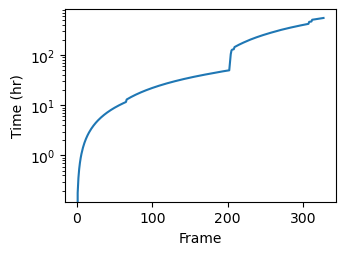

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.semilogy(data['time'] / 60)

ax.set_xlabel('Frame')
ax.set_ylabel('Time (hr)')

Interpolate along a grid

In [6]:
log_times = np.logspace(-0.6, 2.6, 256)
raw_spectra = np.stack(data['raw_signal'].tolist())

In [7]:
inter_spectra = np.zeros((log_times.shape[0], raw_spectra.shape[1]))
for j in tqdm(range(raw_spectra.shape[1])):
    inter_spectra[:, j] = interp1d(data['time'] / 60, raw_spectra[:, j])(log_times)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5838/5838 [00:00<00:00, 8082.64it/s]


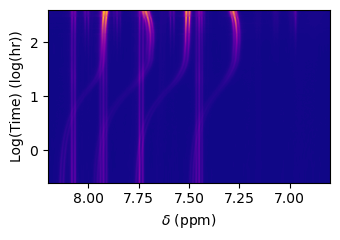

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.imshow(inter_spectra, aspect='auto', origin='lower', cmap='plasma',
          extent=[span[0], span[1], np.log10(log_times[0]), np.log10(log_times[-1])])

ax.set_ylabel('Log(Time) (log(hr))')
ax.set_xlabel('$\delta$ (ppm)')

fig.tight_layout()

Looks close to what Ilya sent me earlier. Let's re-package

In [9]:
inter_data = pd.DataFrame({'time_hr': log_times, 'signal': inter_spectra.tolist()})
inter_data.head()

,time_hr,signal
0,0.251189,"[-0.011402525098837143, -0.006819361194174801,..."
1,0.258553,"[-0.013280717696278158, -0.008543362017989643,..."
2,0.266133,"[-0.015213972705430793, -0.010317904859317176,..."
3,0.273935,"[-0.01720390437458226, -0.012144471443397281, ..."
4,0.281966,"[-0.019252174276454974, -0.01402458693476643, ..."


## Do some peak detection
Detect peaks for each spectrum separately, without considering the others. 

We'll first demonstrate on the first spectrum

In [10]:
example_signal = np.array(inter_data['signal'][0])

In [11]:
peaks, props = find_peaks(example_signal, **peak_kwargs)
print(f'Found {len(peaks)} peaks')

Found 18 peaks


(8.2, 6.8)

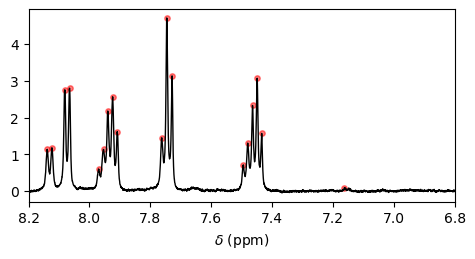

In [12]:
fig, ax = plt.subplots(figsize=(5.5, 2.5))

nmr = ax.plot(offsets, example_signal, 'k', lw=1)
peak_locs = ax.scatter(offsets[peaks], example_signal[peaks], color='r', s=15, alpha=0.5)

ax.set_xlabel('$\delta$ (ppm)')
ax.set_xlim(span)

Make a video

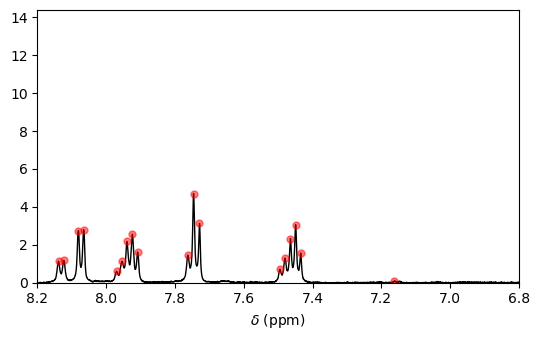

In [13]:
fig, ax = plt.subplots(figsize=(5.5, 3.5))

nmr, = ax.plot(offsets, example_signal, 'k', lw=1)
peak_locs, = ax.plot(offsets[peaks], example_signal[peaks], 'o', color='r', markersize=5, alpha=0.5)

def plot_frame(i):
    # Find the peaks
    signal = np.array(inter_data['signal'][i])
    peaks, props = find_peaks(signal, **peak_kwargs)
    
    # Update the plot
    nmr.set_data(offsets, signal)
    peak_locs.set_data([offsets[peaks], signal[peaks]])
    return nmr, peak_locs
    
ax.set_xlabel('$\delta$ (ppm)')
ax.set_xlim(span)
ax.set_ylim([0, inter_spectra.max()])
fig.tight_layout()

ani = animation.FuncAnimation(fig, plot_frame, frames=len(inter_data), interval=15 / len(inter_data))
writer = animation.FFMpegWriter(fps=15, bitrate=16000)
ani.save(f"init_peaks.mp4", writer=writer, dpi=320)

Repeat, storing the peak locations

In [14]:
def store_peak_locations(signal, **kwargs) -> np.array:
    """Store the offset and height of each peak
    
    Args:
        signal: NMR signal to be processed
        Keyword arguments are passed to `find_peaks`
    Returns:
        Coordinates of each peak
    """
    signal = np.array(signal)
    peaks, props = find_peaks(signal, **kwargs)
    return np.stack((offsets[peaks], signal[peaks]), axis=1)

In [15]:
inter_data['peak_locs'] = inter_data['signal'].apply(lambda x: store_peak_locations(x, **peak_kwargs))

Save it for later analysis

In [16]:
%%time
inter_data.to_pickle('peak_data.pkl.gz')

CPU times: user 773 ms, sys: 13.5 ms, total: 786 ms
Wall time: 789 ms
